# Training of quantum circuit, Torch + pennylane

This notebook explore the creation of quantum circuit with pennylane and training them with torch optimiser.

The first part of this notebook embeds the Q curcuit between two torch classical layers.
The second part is to use pure quantum circuit.

In [1]:
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from train import train

torch.manual_seed(123)

from IPython.display import clear_output

In [2]:
device = torch.device('cpu') # not support for rx5700
n_qubits = 2

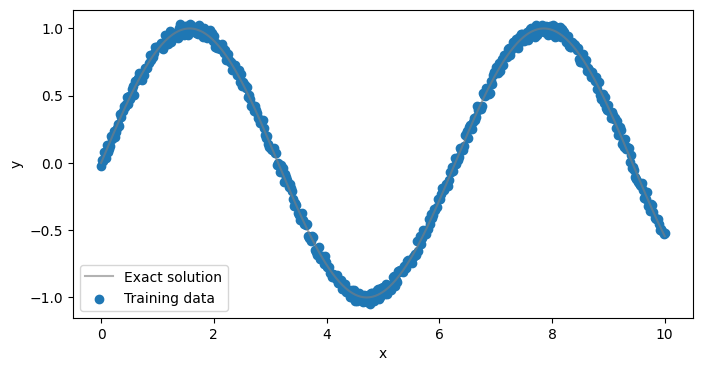

In [3]:
x = torch.linspace(0,10,500).view(-1,1)
y = torch.sin(x)
y = y + 0.1*(torch.rand(500).view(-1,1)-0.5)

plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(x, y, label="Training data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [4]:
class QN(nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()
        self.clayer_1= nn.Linear(N_INPUT, N_QUBITS)
        self.qlayer_1 = Q_NODE
        self.clayer_2 = nn.Linear(N_QUBITS, N_OUTPUT)

    def forward(self, x):
        x = self.clayer_1(x)
        x = self.qlayer_1(x)
        x = self.clayer_2(x)
        return x
    
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)

dev = qml.device("default.qubit.torch", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

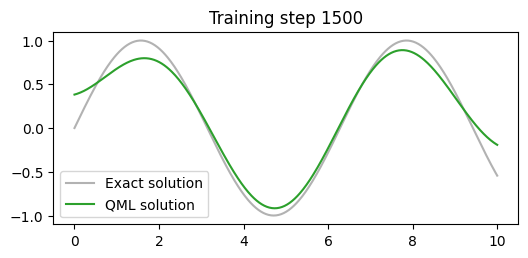

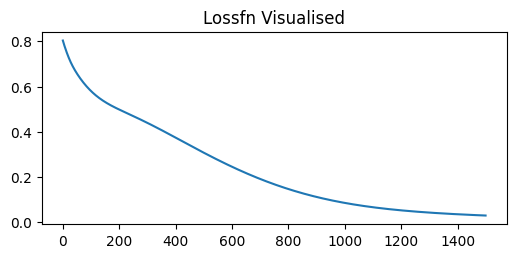

In [6]:
qmodel = QN(1, 1, qlayer, n_qubits)

x = x.requires_grad_(True)
x_train = x.requires_grad_(True)

learning_rate=1e-3
optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)

losses = []

def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="QML solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)
    


train(x_train, y, qmodel, optimiser, 1500, special_loss_fn, callback)

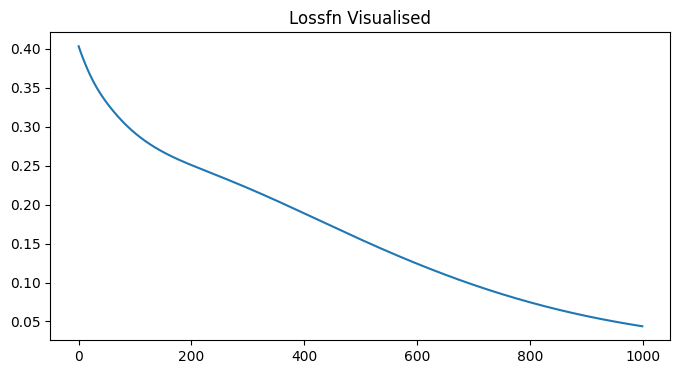

In [ ]:
plt.figure(figsize=(8,4))
plt.title('Lossfn Visualised')
plt.plot(losses)

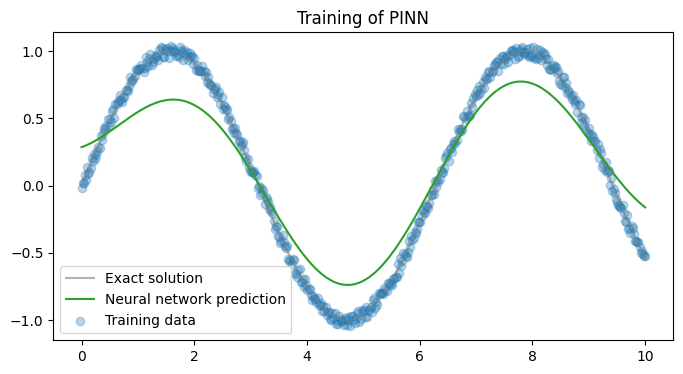

In [ ]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, alpha=0.3, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    x.detach(),
    torch.sin(x).detach(),
    x.detach(),
    y.detach(),
    qmodel(x).detach(),
    title='Training of PINN'
    )

In [ ]:
mse(qmodel(x), torch.sin(x))

tensor(0.0032, grad_fn=<MeanBackward0>)